# Compulsory 3 - Erlend Risvik


## Imports and loading data

In [65]:
import pandas as pd
from pyspark.sql import SparkSession
import os
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact


os.environ["PYSPARK_PYTHON"] = "python"

spark = SparkSession.builder.appName('SparkCassandraApp').\
    config('spark.jars.packages', 'com.datastax.spark:spark-cassandra-connector_2.12:3.4.1').\
    config('spark.cassandra.connection.host', 'localhost').\
    config('spark.sql.extensions', 'com.datastax.spark.connector.CassandraSparkExtensions').\
    config('spark.sql.catalog.mycatalog', 'com.datastax.spark.connector.datasource.CassandraCatalog').\
    config('spark.cassandra.connection.port', '9042').getOrCreate()

(spark.read.format("org.apache.spark.sql.cassandra")
 .options(table="fish_data_full", keyspace="compulsory")
 .load()
 .createOrReplaceTempView("fish_data_full"))

fish_data = spark.sql("SELECT * FROM fish_data_full").toPandas()

(spark.read.format("org.apache.spark.sql.cassandra")
 .options(table="lice_data_full", keyspace="compulsory")
 .load()
 .createOrReplaceTempView("lice_data_full"))

lice_data = spark.sql("SELECT * FROM lice_data_full").toPandas()

In [63]:
fish_data.head()
fish_data.columns

Index(['localityweekid', 'avgadultfemalelice', 'hascleanerfishdeployed',
       'hasila', 'hasmechanicalremoval', 'haspd', 'hasreportedlice',
       'hassalmonoids', 'hassubstancetreatments', 'infilteredselection',
       'isfallow', 'isonland', 'isslaughterholdingcage', 'lat', 'localityno',
       'lon', 'municipality', 'municipalityno', 'name', 'week', 'year',
       'region'],
      dtype='object')

In [10]:
lice_data.head()

,id,avgadultfemalelice,avgmobilelice,avgstationarylice,hasbathtreatment,hascleanerfishdeployed,hasinfeedtreatment,hasmechanicalremoval,hasreportedlice,hassalmonoids,isfallow,isslaughterholdingcage,localityno,seatemperature,week,year
0,187305,0.10,0.10,0.50,True,True,False,False,True,True,False,False,24175,9.2,42,2015
1,187281,0.00,0.02,0.13,False,False,False,False,True,True,False,False,24175,4.0,18,2015
2,187315,0.04,0.15,0.21,False,True,False,False,True,True,False,False,24175,5.2,52,2015
3,187271,0.00,0.00,0.00,False,False,False,False,True,True,False,False,24175,3.3,8,2015
4,187272,NaN,NaN,NaN,False,False,False,False,False,True,False,False,24175,3.3,9,2015


## Pivoting

In [66]:
# We start by creating  a variable called a variable region, splitting Norway into three regions:
# South - below 63.81 latitude, Middle - up to 68.85 latitude, North - above 68.85 latitude

fish_data['region'] = fish_data['lat'].apply(lambda x: 'South' if x < 63.81 else ('Middle' if x < 68.85 else 'North'))
fish_data[["lat", "region"]].head(10)

,lat,region
0,64.186363,Middle
1,69.961670,North
2,61.735867,South
3,64.494934,Middle
4,58.974716,South
5,59.117168,South
6,59.657349,South
7,59.866501,South
8,59.944218,South
9,70.627296,North


In [34]:
# Next, we pivot using week as category and avgAdultFemaleLice as value
lice_data.groupby("week", dropna = False).agg({"avgadultfemalelice": "mean"}).reset_index().head(52)

,week,avgadultfemalelice
0,1,NaN
1,2,0.00
2,3,0.00
3,4,0.00
4,5,NaN
5,6,0.00
6,7,NaN
7,8,0.00
8,9,NaN
9,10,0.00


In [51]:
# Next, we create a pivot table for categories hasPd and hasIla with values lat

fish_data.pivot_table(index = "haspd", columns = "hasila", values = "lat", aggfunc = "mean")

hasila,False,True
haspd,,
False,63.946201,67.401024
True,61.677021,63.141956


In [58]:
# Finally, we create a pivot table for week and region with values avgAdultFemaleLice

pivot = fish_data.pivot_table(columns = "region", index = "week", values = "avgadultfemalelice", aggfunc = "mean")
# sort the columns to get "South", "Middle", "North"
pivot = pivot[["South", "Middle", "North"]]
pivot

region,South,Middle,North
week,,,
1,0.257882,0.157852,0.098125
2,0.280702,0.155034,0.140270
3,0.284847,0.172624,0.055584
4,0.258397,0.169366,0.053143
5,0.281707,0.169348,0.056842
6,0.231207,0.157710,0.054528
7,0.192832,0.168240,0.050800
8,0.209759,0.141694,0.063167
9,0.201831,0.134375,0.066780


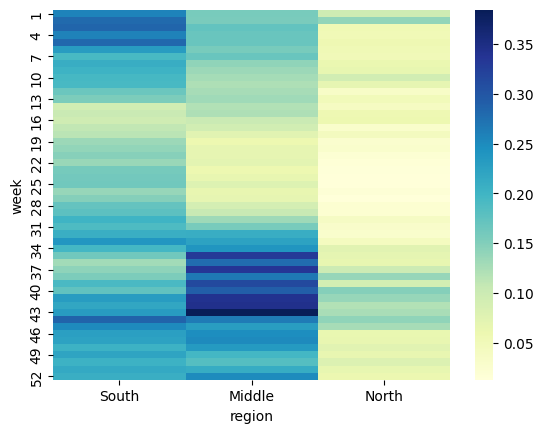

In [59]:
sns.heatmap(pivot, cmap = "YlGnBu")
plt.show()

- We can see from the first pivot that lice is most previlent in hot weather, i.e. when the the weeks inccrease towards summer, the lice count increases.
- The second table shows that where hasPD is False and hasIla is True, the average of this occurence is higher up in Norway than for the other cases. On the other hand, where hasPD is True and hasIla is False, this occurence happens more often in the south of Norway.
- Finally, the third table shows that:
    - South has high lice count at the beginning and end of year.
    - Middle has high lice count from middle of the year to the end of the year.
    - North has on average the lowest lice count compared to both of the other regions.


## Forecasting

In [81]:
# we start by imputing 0 where there is no data
cols = ["avgadultfemalelice", "avgstationarylice", "avgmobilelice"]
lice_data[cols] = lice_data[cols].fillna(0)

In [82]:
lice = lice_data['seatemperature'].rolling(5, center=True).corr(lice_data['avgadultfemalelice'])

def plot_lice(center=22):
    plt.subplot(3,1,1)
    plt.plot(lice_data['seatemperature'])
    plt.plot(range(center-22,center+22), lice_data['seatemperature'][center-22:center+22], color="red")
    plt.ylabel('seatemperature')
    plt.xlim(0, len(lice_data['seatemperature']))
    plt.subplot(3,1,2)
    plt.plot(lice_data['avgadultfemalelice'])
    plt.plot(range(center-22,center+22), lice_data['avgadultfemalelice'][center-22:center+22], color="red")
    plt.ylabel('avgadultfemalelice')
    plt.xlim(0, len(lice_data['seatemperature']))
    plt.subplot(3,1,3)
    plt.plot(lice)
    plt.plot(center, lice[center], 'r.')
    plt.axhline(y=0, color='gray', linestyle=':')
    plt.ylim(-1,1)
    plt.xlim(0, len(lice_data['seatemperature']))
    plt.xlabel('Time')
    plt.ylabel('Correlation')
    plt.show()

interact(plot_lice, center=(22,len(lice_data['seatemperature'])-23,1)); # Semi-colon to suppress output

interactive(children=(IntSlider(value=22, description='center', max=29, min=22), Output()), _dom_classes=('wid…

In [79]:
lice

0          NaN
1          NaN
2    -0.257825
3    -0.270789
4     0.512859
5          NaN
6          NaN
7          NaN
8          NaN
9          NaN
10         NaN
11    0.382755
12    0.526159
13   -0.129373
14   -0.197815
15   -0.214383
16    0.603312
17    0.611459
18    0.926715
19    0.825064
20         NaN
21         NaN
22         NaN
23         NaN
24         NaN
25    0.975190
26    0.469255
27    0.232444
28    0.169372
29    0.672151
30         NaN
31         NaN
32         NaN
33         NaN
34         NaN
35         NaN
36         NaN
37         NaN
38         NaN
39         NaN
40         NaN
41         NaN
42         NaN
43         NaN
44         NaN
45   -0.239998
46   -0.557689
47   -0.460685
48         NaN
49         NaN
50         NaN
51         NaN
dtype: float64